In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

In [75]:
class SpatialDenoiserDataset(Dataset):
    
    def __init__(self,
                 root_dir: str = 'IntSpatialData',
                 expand_dims: bool = True,
                 apply_pad: bool = True):
        
        self.root_dir = root_dir
        self.expand_dims = expand_dims
        self.apply_pad = apply_pad
        self.run_names = sorted(os.listdir(self.root_dir))
        if '.DS_Store' in self.run_names:
            self.run_names.remove('.DS_Store')
        self.coords = []
        for run_name in self.run_names:
            noisy_files, clean_files = [], []
            filenames = os.listdir(os.path.join(root_dir, run_name))
            for file in filenames:
                if '_UV_' in file:
                    clean_files.append(file)
                elif '_Inj_' in file:
                    noisy_files.append(file)
            clean_files = sorted(clean_files)
            noisy_files = sorted(noisy_files)
            assert len(clean_files) == len(noisy_files)
            for i in range(len(clean_files)):
                tup = (root_dir, run_name, clean_files[i], noisy_files[i])
                self.coords.append(tup)
    
    def __len__(self):
        return len(self.coords)
    
    def __getitem__(self, idx):
        _, run_name, clean_filename, noisy_filename = self.coords[idx]
        clean_csv = pd.read_csv(os.path.join(self.root_dir, run_name, clean_filename))
        noisy_csv = pd.read_csv(os.path.join(self.root_dir, run_name, noisy_filename))
        
        clean_img = np.array(clean_csv)
        noisy_img = np.array(noisy_csv)
        
        if self.apply_pad:
            pad = np.zeros((1, 256))
            clean_img = np.vstack((clean_img, pad))
            noisy_img = np.vstack((noisy_img, pad))
        
        if self.expand_dims:
            clean_img = np.expand_dims(clean_img, axis = 0)
            noisy_img = np.expand_dims(noisy_img, axis = 0)
        
        noisy_img = torch.from_numpy(noisy_img)
        clean_img = torch.from_numpy(clean_img)
        
        
        return noisy_img.to(torch.float32), clean_img.to(torch.float32)

In [76]:
dataset = SpatialDenoiserDataset()
trainloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [77]:
# trainiter = iter(trainloader)
inputs, labels = next(trainiter)
print(inputs.shape)
print(labels.shape)

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


In [78]:
len(trainloader)

73

In [79]:
class SuperResolution(nn.Module):
    """
    Network Architecture as per specified in the paper. 
    The chosen configuration for successive filter sizes are 9-5-5
    The chosed configuration for successive filter depth are 128-64(-3)
    """
    def __init__(self, sub_image: int = 33, spatial: list = [9, 5, 5], filter: list = [128, 64], num_channels: int = 1):
        super().__init__()
        self.layer_1 = nn.Conv2d(num_channels, filter[0], spatial[0], padding = spatial[0] // 2)
        self.layer_2 = nn.Conv2d(filter[0], filter[1], spatial[1], padding = spatial[1] // 2)
        self.layer_3 = nn.Conv2d(filter[1], num_channels, spatial[2], padding = spatial[2] // 2)
        self.relu = nn.ReLU()

    def forward(self, image_batch):
        x = self.layer_1(image_batch)
        x = self.relu(x)
        x = self.layer_2(x)
        y = self.relu(x)
        x = self.layer_3(y)
        return x, y 

In [16]:
# Instantiate the model
model = SuperResolution()

# Define the loss function (Mean Squared Error for denoising task)
# criterion = nn.L1Loss()
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
device='cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 10
batch_size = 16

In [58]:
best_val_loss = float('inf')
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch+1}, batch_id: {batch_idx+1}, batch train loss: {loss.item()}")
        print("\n")
    train_losses.append(total_loss/len(trainloader))
    print(f"Epoch: {epoch + 1}/ {num_epochs}, Loss: {total_loss/len(trainloader)}")
    print("-"*50)
    print("\n")

Epoch: 1, batch_id: 1, batch train loss: 0.001927498378790915


Epoch: 1, batch_id: 2, batch train loss: 0.0011222937610000372


Epoch: 1, batch_id: 3, batch train loss: 0.0021265209652483463


Epoch: 1, batch_id: 4, batch train loss: 0.0014591554645448923


Epoch: 1, batch_id: 5, batch train loss: 0.0017998235998675227


Epoch: 1, batch_id: 6, batch train loss: 0.001884519588202238


Epoch: 1, batch_id: 7, batch train loss: 0.0026567443273961544


Epoch: 1, batch_id: 8, batch train loss: 0.0018061930313706398


Epoch: 1, batch_id: 9, batch train loss: 0.001651024678722024


Epoch: 1, batch_id: 10, batch train loss: 0.001865824218839407


Epoch: 1, batch_id: 11, batch train loss: 0.001275019021704793


Epoch: 1, batch_id: 12, batch train loss: 0.0015356459189206362


Epoch: 1, batch_id: 13, batch train loss: 0.0020054627675563097


Epoch: 1, batch_id: 14, batch train loss: 0.0018696028273552656


Epoch: 1, batch_id: 15, batch train loss: 0.002256724052131176


Epoch: 1, batch_id: 16, b

Epoch: 2, batch_id: 52, batch train loss: 0.0026994911022484303


Epoch: 2, batch_id: 53, batch train loss: 0.0019727174658328295


Epoch: 2, batch_id: 54, batch train loss: 0.0019470695406198502


Epoch: 2, batch_id: 55, batch train loss: 0.002615931211039424


Epoch: 2, batch_id: 56, batch train loss: 0.002270943019539118


Epoch: 2, batch_id: 57, batch train loss: 0.0010312728118151426


Epoch: 2, batch_id: 58, batch train loss: 0.0016818123403936625


Epoch: 2, batch_id: 59, batch train loss: 0.0014181850710883737


Epoch: 2, batch_id: 60, batch train loss: 0.002159446943551302


Epoch: 2, batch_id: 61, batch train loss: 0.0014220643788576126


Epoch: 2, batch_id: 62, batch train loss: 0.0018052258528769016


Epoch: 2, batch_id: 63, batch train loss: 0.0012026516487821937


Epoch: 2, batch_id: 64, batch train loss: 0.001807036460377276


Epoch: 2, batch_id: 65, batch train loss: 0.002003834117203951


Epoch: 2, batch_id: 66, batch train loss: 0.001193830743432045


Epoch: 2, batch_

Epoch: 4, batch_id: 29, batch train loss: 0.0018922415329143405


Epoch: 4, batch_id: 30, batch train loss: 0.0021171134430915117


Epoch: 4, batch_id: 31, batch train loss: 0.001354482490569353


Epoch: 4, batch_id: 32, batch train loss: 0.002200532238930464


Epoch: 4, batch_id: 33, batch train loss: 0.001790231908671558


Epoch: 4, batch_id: 34, batch train loss: 0.0009925529593601823


Epoch: 4, batch_id: 35, batch train loss: 0.002168366452679038


Epoch: 4, batch_id: 36, batch train loss: 0.0024150905665010214


Epoch: 4, batch_id: 37, batch train loss: 0.0013609841698780656


Epoch: 4, batch_id: 38, batch train loss: 0.0018253846792504191


Epoch: 4, batch_id: 39, batch train loss: 0.002575017511844635


Epoch: 4, batch_id: 40, batch train loss: 0.0009163509821519256


Epoch: 4, batch_id: 41, batch train loss: 0.002159381750971079


Epoch: 4, batch_id: 42, batch train loss: 0.0016796896234154701


Epoch: 4, batch_id: 43, batch train loss: 0.0013228157768025994


Epoch: 4, batch_

Epoch: 6, batch_id: 6, batch train loss: 0.002329731360077858


Epoch: 6, batch_id: 7, batch train loss: 0.0011251335963606834


Epoch: 6, batch_id: 8, batch train loss: 0.0015399066032841802


Epoch: 6, batch_id: 9, batch train loss: 0.0023932899348437786


Epoch: 6, batch_id: 10, batch train loss: 0.0018238585907965899


Epoch: 6, batch_id: 11, batch train loss: 0.0013097816845402122


Epoch: 6, batch_id: 12, batch train loss: 0.0010978521313518286


Epoch: 6, batch_id: 13, batch train loss: 0.0010586426360532641


Epoch: 6, batch_id: 14, batch train loss: 0.001918587600812316


Epoch: 6, batch_id: 15, batch train loss: 0.002568062860518694


Epoch: 6, batch_id: 16, batch train loss: 0.0015460087452083826


Epoch: 6, batch_id: 17, batch train loss: 0.002619033446535468


Epoch: 6, batch_id: 18, batch train loss: 0.0019042256753891706


Epoch: 6, batch_id: 19, batch train loss: 0.0021519919391721487


Epoch: 6, batch_id: 20, batch train loss: 0.002968906657770276


Epoch: 6, batch_id:

Epoch: 7, batch_id: 57, batch train loss: 0.0010272770887240767


Epoch: 7, batch_id: 58, batch train loss: 0.0019809058867394924


Epoch: 7, batch_id: 59, batch train loss: 0.0045635090209543705


Epoch: 7, batch_id: 60, batch train loss: 0.002646519336849451


Epoch: 7, batch_id: 61, batch train loss: 0.0016092286678031087


Epoch: 7, batch_id: 62, batch train loss: 0.002254180144518614


Epoch: 7, batch_id: 63, batch train loss: 0.0017989369807764888


Epoch: 7, batch_id: 64, batch train loss: 0.0015724172117188573


Epoch: 7, batch_id: 65, batch train loss: 0.0011692257830873132


Epoch: 7, batch_id: 66, batch train loss: 0.0011230157688260078


Epoch: 7, batch_id: 67, batch train loss: 0.0022207938600331545


Epoch: 7, batch_id: 68, batch train loss: 0.001770421164110303


Epoch: 7, batch_id: 69, batch train loss: 0.0012565479846671224


Epoch: 7, batch_id: 70, batch train loss: 0.0009819279657676816


Epoch: 7, batch_id: 71, batch train loss: 0.002481701783835888


Epoch: 7, batc

Epoch: 9, batch_id: 34, batch train loss: 0.001362300245091319


Epoch: 9, batch_id: 35, batch train loss: 0.0025020006578415632


Epoch: 9, batch_id: 36, batch train loss: 0.0017265832284465432


Epoch: 9, batch_id: 37, batch train loss: 0.0015793214552104473


Epoch: 9, batch_id: 38, batch train loss: 0.0010702786967158318


Epoch: 9, batch_id: 39, batch train loss: 0.0012932070530951023


Epoch: 9, batch_id: 40, batch train loss: 0.0014671430690214038


Epoch: 9, batch_id: 41, batch train loss: 0.001532700494863093


Epoch: 9, batch_id: 42, batch train loss: 0.0007833444396965206


Epoch: 9, batch_id: 43, batch train loss: 0.0013414130080491304


Epoch: 9, batch_id: 44, batch train loss: 0.0014728083042427897


Epoch: 9, batch_id: 45, batch train loss: 0.0016048921970650554


Epoch: 9, batch_id: 46, batch train loss: 0.0028324166778475046


Epoch: 9, batch_id: 47, batch train loss: 0.0014040280366316438


Epoch: 9, batch_id: 48, batch train loss: 0.0016325260512530804


Epoch: 9, ba

In [80]:
testdataset = SpatialDenoiserDataset(root_dir = 'IntSpatialTestData')
testloader = DataLoader(testdataset, batch_size=16, shuffle=False)

In [71]:
# testiter = iter(testloader)
test_inputs, test_labels = next(testiter)

In [72]:
outputs, _ = model(test_inputs)

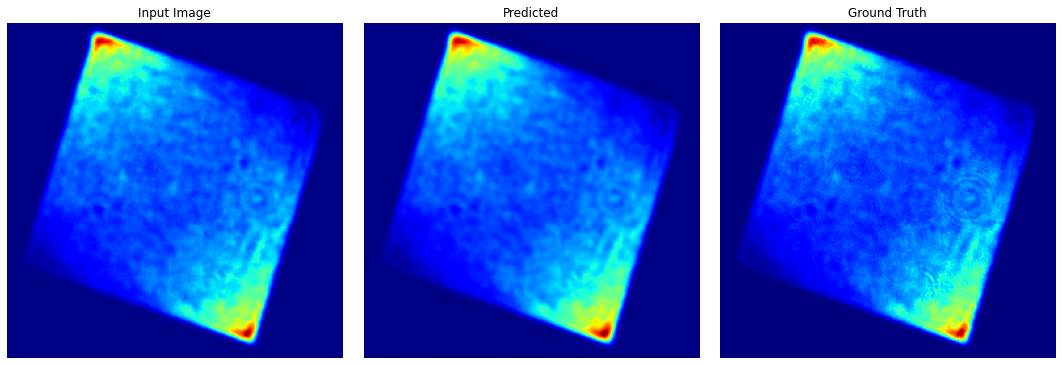

In [73]:
# Create a figure with 1 row and 3 columns for the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display input image
axes[0].imshow(test_inputs[1][0].cpu().detach().numpy(), cmap = 'jet')
axes[0].set_title('Input Image')
axes[0].axis('off')  # Turn off axis

# Display predicted image
axes[1].imshow(outputs.detach().numpy()[1][0], cmap = 'jet')
axes[1].set_title('Predicted')
axes[1].axis('off')  # Turn off axis

# Display ground truth image
axes[2].imshow(test_labels[1][0].cpu().detach().numpy(), cmap = 'jet')
axes[2].set_title('Ground Truth')
axes[2].axis('off')  # Turn off axis

# Display the plot
plt.tight_layout()
plt.show()